# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Kuan Tung  
**Group Members:** Chun-Hung Yeh, Zhuoyue Wang  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Import packages

In [1]:
import cv2 as cv
import numpy as np
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
from scipy import ndimage as ndi

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

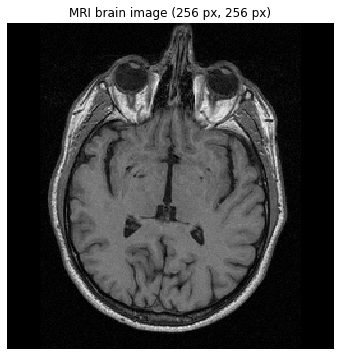

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)
Add your implementation and discussion

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [6]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


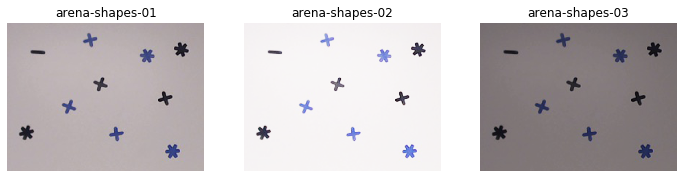

In [7]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color

Our routine is straightforward. We first detect the contour of the shapes, and then decide what color are those shapes. We will show our implementation detail in the following cells.

In order to get a better contour detection, we perform a series of preprocessing:  

1. Convert the image to grayscale because we will not use color information when detecing contours.
2. Adaptively threshold the image. The threshold is computed for each small region by subtracting a constant C (the last argument) from the gaussian-weighted sum of the neighborhood values. We set the constant C = 2 and neighborhood size = 51 by trial and error. It will give a better result compared to fixed thresholding.
3. Make the foreground white and the background black by inverting the image.
4. Use morphology to remove small objects and fill small holes so that we can get a correct segmentation of foreground and background. We set the minimum size = 100.

In [8]:
def preprocess(image):
    """Preprocess the image for better contour detection.
    
    Args:
        image (numpy.ndarray): The input image.
    Return:
        numpy.ndarray: A black and white version of the input image with low noise.
    """
    # convert to grayscale
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    # adaptively threshold the image
    th_image = cv.adaptiveThreshold(gray_image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 51, 2)
    # invert the image
    inv_th_image = ~th_image
    # remove small noises using morphology
    clean_image = remove_small_objects(inv_th_image.astype(bool), min_size=100)
    # fill holes using morphology
    filled_image = ndi.binary_fill_holes(clean_image).astype(np.uint8)
    return filled_image

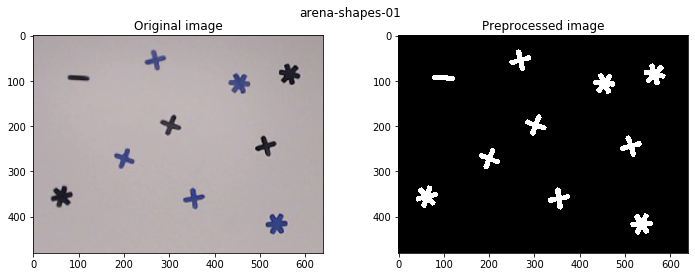

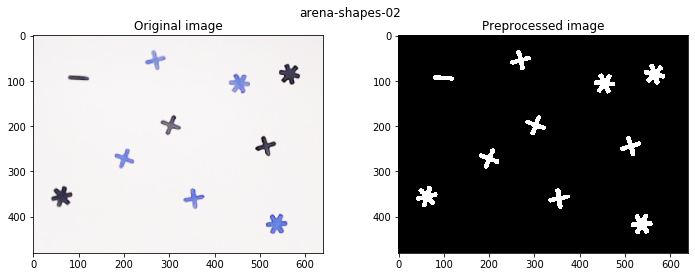

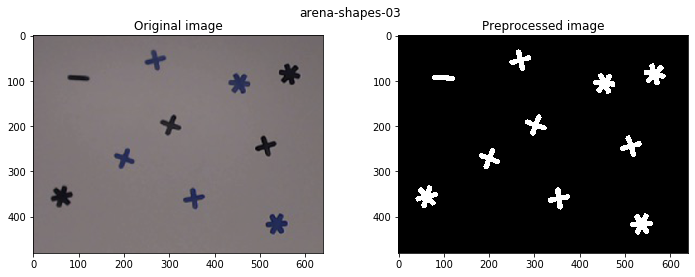

In [9]:
# plot the preprocessed images
for i in range(3):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(im_names[i])
    axes[0].imshow(images[i])
    axes[0].set_title('Original image')
    axes[1].imshow(preprocess(images[i]), cmap='gray')
    axes[1].set_title('Preprocessed image')

The foreground and background of all three images are nicely separated.  This will be useful when detecting contours.
___

Since our routine has to be robust to illumination changes, we normalize the image to make intensities of the images comparable:  

1. We use [Yen's method](https://doi.org/10.1109/83.366472) to find a threshold value that separates the distribution in the intensity histogram.
2. Rescale the intensity with the threshold value.

In [10]:
def normalize(image):
    """Normalize the image to handle illumination differences.
    
    Args:
        image (numpy.ndarray): The input image.
    Return:
        numpy.ndarray: A normalized image in terms of intensity.
    """
    # get the threshold using Yen's method
    yen_threshold = threshold_yen(image)
    # rescale the intensity with the threshold
    normalized = rescale_intensity(image, (0, yen_threshold), (0, 255))
    
    return normalized

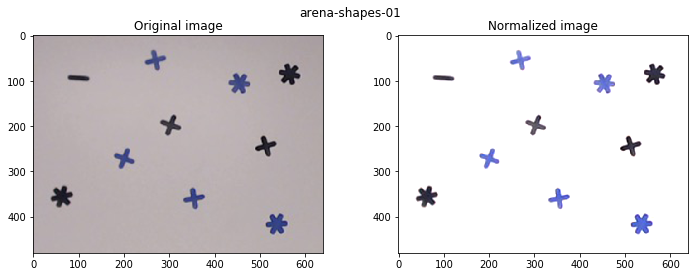

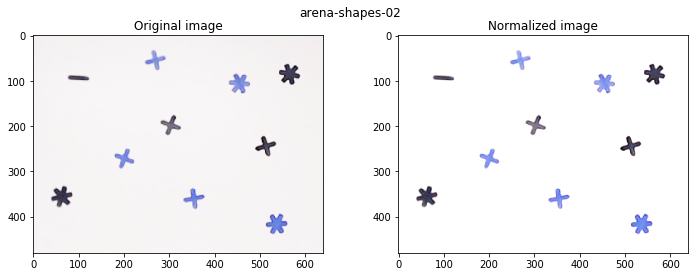

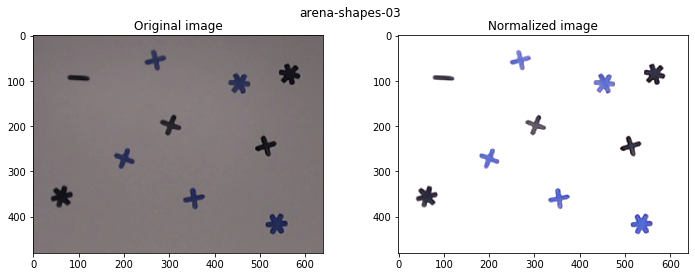

In [11]:
# plot the normalized images
for i in range(3):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(im_names[i])
    axes[0].imshow(images[i])
    axes[0].set_title('Original image')
    axes[1].imshow(normalize(images[i]))
    axes[1].set_title('Normalized image')

The illumination differences in the normalized images are less than the ones in the original images.
___

When detecting the color of a shape, we only look at one of the pixel since all the shapes have uniformly distributed colors.  

We convert the image to HSV (Hue, Saturation and Value) representation and check whether the value of a point is within a predefined range belonged to a certain color. The reason we do it in HSV is because we can much easily separate colors with hue (one value instead of three values, RGB). We still need to look at saturation and brightness to separate black from other colors.

In [12]:
# these ranges are set by trial and error
color_range = {
    'blue': [(100, 90, 140), (130, 255, 255)],
    'black': [(0, 0, 0), (179, 90, 140)]
}

In [13]:
def detect_color(image, pixel, color_range=color_range):
    """Detect the color of a pixel in the image.
    
    Args:
        image (numpy.ndarray): The input image.
        pixel (tuple): The position you want to detect the color.
        color_range (dict): The accepted range (in HSV) for all the considered colors.
    Return:
        str: The name of the color.
    """
    # set a default color the prevent error when no color is detected
    color = list(color_range.keys())[0]
    # convert the image to HSV
    hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    # loop through the color we want to detect
    for key, range_ in color_range.items():
        # use the color range (in HSV) to set up a mask
        mask = cv.inRange(hsv_image, range_[0], range_[1])
        # the pixel is within the range of the color
        if mask[pixel] == 255:
            color = key
            break
    return color

The color of the pixel (indicated by the red dot) in the following image is black


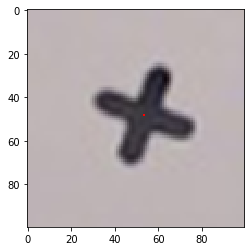

In [14]:
# an example to show detect_color works
tmp = images[0].copy()
tmp[198, 303] = [255, 0, 0]
# plot a part of the image
plt.imshow(tmp[150:250, 250:350])
print(f'The color of the pixel (indicated by the red dot) in the following image is {detect_color(images[0], (198, 303))}')

___

Finally, we combine all the functions and perform our main task:  

1. Preprocess the image.
2. Use `cv2.findContours` to get all the contours. `cv2.RETR_LIST` is set because we don't need hierarchical relationships. `cv2.CHAIN_APPROX_SIMPLE` is set because it will save a lot of memory without any major disadvantage. The details of these two mode are shown in the next cell.
3. For each contours, we use `cv2.moments` to find the centroid of the shape and detect the color of it. Here we use the normalized image as input.
4. We can now count how many shapes of each color and visualize the result.

The following descriptions were copied from the [document](https://docs.opencv.org/trunk/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) of OpenCV:  
`cv2.RETR_LIST`: retrieves all of the contours without establishing any hierarchical relationships.  
`cv2.CHAIN_APPROX_SIMPLE`: compresses horizontal, vertical, and diagonal segments and leaves only their end points. For example, an up-right rectangular contour is encoded with 4 points.

In [15]:
def count_shapes(image, color_range=color_range):
    """Count the number of shapes of each color in the image.
    
    Args:
        image (numpy.ndarray): The input image.
        color_range (dict): The accepted range (in HSV) for all the considered colors.
    """
    # copy the image for the final visualization
    image_copy = image.copy()
    # counter dictionary to store how many shapes of each color
    shapes_ctn = {key: 0 for key in color_range.keys()}
    
    # preprocess the image
    preprocessed_image = preprocess(image)
    # get the contours of all shapes
    contours, _ = cv.findContours(preprocessed_image, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    print(f'Total number of shapes: {len(contours)}')
    
    for c in contours:
        # compute the centroid of the shapes
        M = cv.moments(c)
        cY = int(M['m01'] / M['m00'])
        cX = int(M['m10'] / M['m00'])
        center = (cY, cX)
        
        # detect the color color of the centroid
        color = detect_color(normalize(image), center)
        shapes_ctn[color] += 1
        
        # visualize the result on the image
        label_color = (214, 39, 40)
        cv.drawContours(image_copy, [c], 0, label_color, 2)
        cv.putText(image_copy, color, (cX, cY + 30), cv.FONT_HERSHEY_SIMPLEX, 0.8, label_color, 2)
        
    for color in color_range.keys():
        print(f'Number of {color} shapes: {shapes_ctn[color]}')
        
    plt.imshow(image_copy)
    plt.show()

---------------------------------------------
Counting shapes for arena-shapes-01

Total number of shapes: 10
Number of blue shapes: 5
Number of black shapes: 5


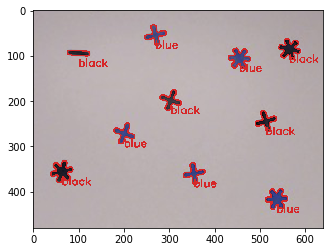

---------------------------------------------
Counting shapes for arena-shapes-02

Total number of shapes: 10
Number of blue shapes: 5
Number of black shapes: 5


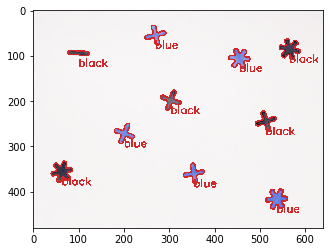

---------------------------------------------
Counting shapes for arena-shapes-03

Total number of shapes: 10
Number of blue shapes: 5
Number of black shapes: 5


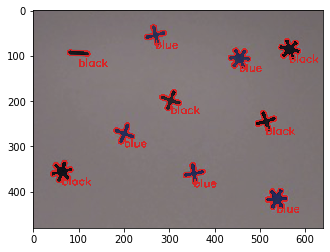

In [16]:
for i in range(3):
    print('-' * 45)
    print(f'Counting shapes for {im_names[i]}')
    print()
    count_shapes(images[i])

Our routine can successfully count the number of shapes of each color.
___

### 2.3 Total area (in pixels) of each color

For computing the total area of each color, we mostly follow the same processes as the previous part. The only difference is we use `cv2.contourArea` to compute the area of each shape.

In [17]:
def compute_area(image, color_range=color_range):
    """Compute the total area of each color in the image.
    
    Args:
        image (numpy.ndarray): The input image.
        color_range (dict): The accepted range (in HSV) for all the considered colors.
    """
    # copy the image for the final visualization
    image_copy = image.copy()
    # dictionary to store the area of each color
    area_ctn = {key: 0 for key in color_range.keys()}
    
    # preprocess the image
    preprocessed_image = preprocess(image)
    # get the contours of all shapes
    contours, _ = cv.findContours(preprocessed_image, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        # compute the centroid of the shapes
        M = cv.moments(c)
        cY = int(M['m01'] / M['m00'])
        cX = int(M['m10'] / M['m00'])
        center = (cY, cX)
        
        # detect the color color of the centroid
        color = detect_color(normalize(image), center)
        # compute the area and save it
        area = int(cv.contourArea(c))
        area_ctn[color] += area
        
        # visualize the result on the image
        label_color = (214, 39, 40)
        cv.drawContours(image_copy, [c], 0, label_color, 2)
        cv.putText(image_copy, color, (cX, cY + 30), cv.FONT_HERSHEY_SIMPLEX, 0.8, label_color, 2)
        cv.putText(image_copy, str(area), (cX, cY + 60), cv.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
        
    for color in color_range.keys():
        print(f'Total area (in pixels) of {color} shapes: {area_ctn[color]}')
        
    plt.imshow(image_copy)
    plt.show()

---------------------------------------------
Computing area for arena-shapes-01

Total area (in pixels) of blue shapes: 5020
Total area (in pixels) of black shapes: 4655


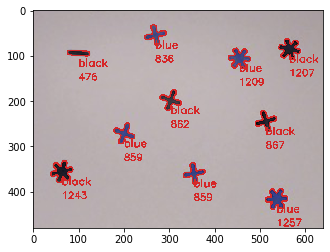

---------------------------------------------
Computing area for arena-shapes-02

Total area (in pixels) of blue shapes: 4430
Total area (in pixels) of black shapes: 4125


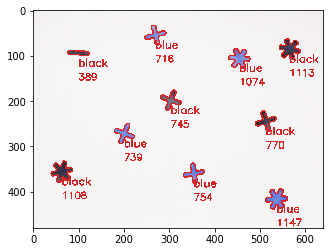

---------------------------------------------
Computing area for arena-shapes-03

Total area (in pixels) of blue shapes: 5100
Total area (in pixels) of black shapes: 4739


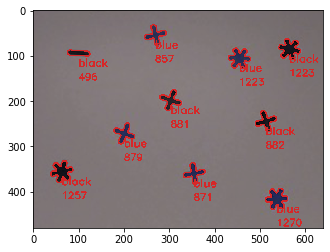

In [18]:
for i in range(3):
    print('-' * 45)
    print(f'Computing area for {im_names[i]}')
    print()
    compute_area(images[i])

It seems like the darker the image is, the more pixels will be counted. The reason could be because in a darker image, the background is darker. The contour finding function will include more pixels since blue and black shapes are more similar to the background.
___